In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression

In [152]:
path = 'in-vehicle-coupon-recommendation.csv'
df = pd.read_csv(path)

In [153]:
X = df.drop('Y', axis= 1)
y = df['Y']
X

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,0,0,0,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,0,0,0,1
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,1,0,0,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,1,0,0,1
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,1,0
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,0,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,0,0,1,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,never,1~3,4~8,1~3,1,1,1,0,1


## Discussion
As we can see in the dataset many of the features of this data consist of categorical values. 
In each of one this variables we may ask if the they have numerical signficance.
For example, we may find that attributing values 1, 2, 3, ... for the income attribute may be a good criteria.
But in the coupon attribute we may find that this way of discretizing is not optimal, instead, we can use a binary criteria.
Which basically means that we can create auxiliary variables that will say if each data point way offered to use a specific coupon.



In [154]:
# Visualizing if the ordinal-scale for the income attribute is a good criteria
# for deciding the response variable.
X['income'].unique()
incomes = [ 'Less than $12500', '$12500 - $24999', '$25000 - $37499',
            '$37500 - $49999', '$50000 - $62499', '$62500 - $74999',
            '$75000 - $87499', '$87500 - $99999', '$100000 or More']
enc = OrdinalEncoder(categories=[incomes])
X['income'] = enc.fit_transform(X[['income']])

In [155]:
zero_counts = { income: 0 for income in X['income'] }
one_counts = { income: 0 for income in X['income'] }

for income, _y in zip( X['income'], y ):
    if _y == 0:
        zero_counts[income] += 1
    else:
        one_counts[income] += 1

In [156]:
# Seems like the cout above is correct, since this works
test = 0
for key, value in zero_counts.items():
    test += value
for key, value in one_counts.items():
    test += value
print(test)

12684


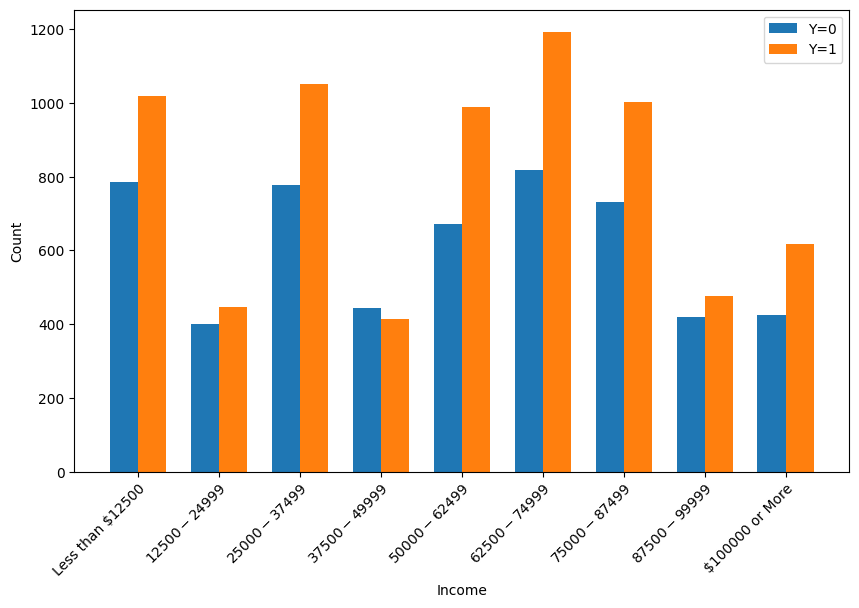

In [157]:
fig_income, axes_income = plt.subplots( figsize=(10, 6) )

bar_width = 0.35
index = np.arange(len(incomes))

bars_y0 = axes_income.bar(index, zero_counts.values(), bar_width, label='Y=0')
bars_y1 = axes_income.bar(index + bar_width, one_counts.values(), bar_width, label='Y=1')

axes_income.set_xlabel('Income')
axes_income.set_ylabel('Count')
axes_income.set_xticks(index+bar_width/2)
axes_income.set_xticklabels(incomes, rotation=45, ha='right', rotation_mode='anchor')
axes_income.legend()

plt.show()

Text(0, 0.5, 'Ratios')

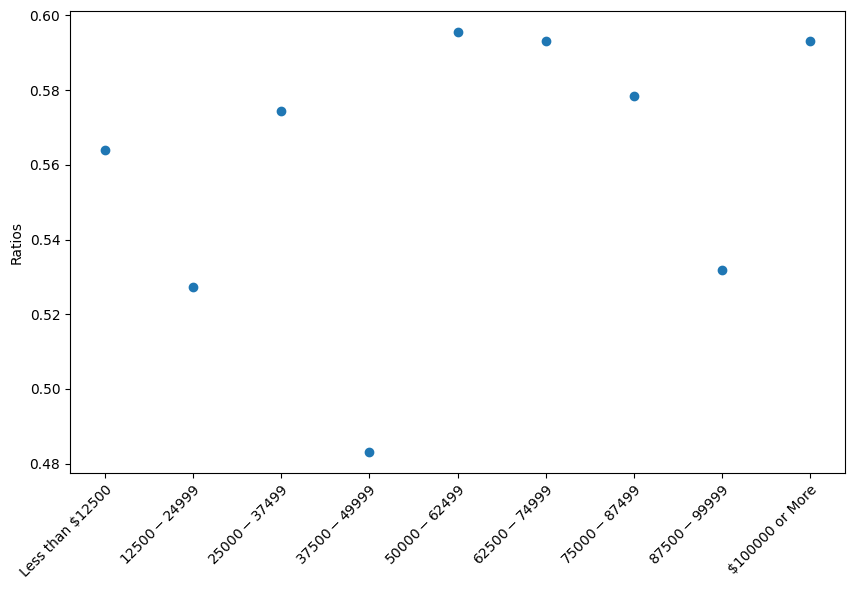

In [158]:
# Clearly there is no relation since the horizontal line is a good candidate to approximating the behaviour
income_ratios = []
list_ones = list(one_counts.values())
list_zeros = list(zero_counts.values())
for i in range(len(list_ones)):
    ratio = list_ones[i] / ( list_ones[i] + list_zeros[i] )
    income_ratios.append( ratio )
fig_ratios, axes_ratios = plt.subplots( figsize=(10, 6) )
xticks = np.arange(len(income_ratios))
axes_ratios.scatter( xticks, income_ratios )

axes_ratios.set_xticks(xticks)
axes_ratios.set_xticklabels(incomes, rotation=45, ha='right', rotation_mode='anchor')
axes_ratios.set_ylabel("Ratios")
    

## Conclusion about income being a ordinal encoder.
As we can see in figure above there is no apparently linear relation in increasing the salary
and incresing the probability of accepting the coupon. So it is not a good idea to use salary as a ordinal encoder.
But for using as a parameter in K-nearest-neighbors, the income attribute may be a good attribute, so we will use it as
a One Hot Encoder.

In [159]:
# redefining the matrices to its original form
path = 'in-vehicle-coupon-recommendation.csv'
df = pd.read_csv(path)
X = df.drop('Y', axis= 1)
y = df['Y']

In [160]:
# Creating a one_hot_encoder for income in the final Matrix.
one_hot_encoder_income = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_incomeTransform = one_hot_encoder_income.fit_transform(X[['income']])
X_final = pd.concat( [X, one_hot_encoder_incomeTransform], axis=1 ).drop( columns= ['income'] )

# Deciding for some variables that are kind of trivial to define its categorical behaviour
---
## Destination
As we can clearly see there is no hierarquy between the attribute **destination**. So we can already assume that we will use them as a One Hot Encoder in the final Matrix.

Notice that this attribute may be essential to define the acceptence of the coupon, since the activity the costumer is going to do is deterministic to accepting the coupon.


In [161]:
# As we can see, there is no worries to handle with unknown data...
np.unique( X['destination'] )

array(['Home', 'No Urgent Place', 'Work'], dtype=object)

In [162]:
one_hot_encoder_destination = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_destinationTransform = one_hot_encoder_destination.fit_transform(X[['destination']])
X_final = pd.concat( [X_final, one_hot_encoder_destinationTransform], axis=1 ).drop( columns=['destination'])

## Passanger
The **passanger** attribute can be seen as the **destination** attribute. Since it can be viewed as some essential data for deciding the coupon acceptence.

In [163]:
# As we can see, there are no unknows.
np.unique( X['passanger'] )

array(['Alone', 'Friend(s)', 'Kid(s)', 'Partner'], dtype=object)

In [164]:
one_hot_encoder_passanger = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_passangerTransform = one_hot_encoder_passanger.fit_transform(X[['passanger']])
X_final = pd.concat( [X_final, one_hot_encoder_passangerTransform], axis=1 ).drop( columns=['passanger'] )
X_final.head(10)

,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,...,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,destination_Home,destination_No Urgent Place,destination_Work,passanger_Alone,passanger_Friend(s),passanger_Kid(s),passanger_Partner
0,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,Sunny,80,6PM,Restaurant(<20),2h,Female,21,Unmarried partner,1,Some college - no degree,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,Sunny,55,2PM,Carry out & Take away,1d,Female,21,Unmarried partner,1,Some college - no degree,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,Sunny,80,10AM,Restaurant(<20),2h,Female,21,Unmarried partner,1,Some college - no degree,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,Sunny,80,10AM,Bar,1d,Female,21,Unmarried partner,1,Some college - no degree,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Weather
The **weather** attribute has no hierarquy. So i will use a One Hot Encoder to discretize the variables.

In [165]:
# No unknow data...
np.unique(X['weather'])

array(['Rainy', 'Snowy', 'Sunny'], dtype=object)

In [166]:
one_hot_encoder_weather = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_weatherTransform = one_hot_encoder_weather.fit_transform(X[['weather']])
X_final = pd.concat( [X_final, one_hot_encoder_weatherTransform], axis=1 ).drop(columns=['weather'])
X_final

,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,...,destination_Home,destination_No Urgent Place,destination_Work,passanger_Alone,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Rainy,weather_Snowy,weather_Sunny
0,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,55,6PM,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
12680,55,7AM,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
12681,30,7AM,Coffee House,1d,Male,26,Single,0,Bachelors degree,Sales & Related,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12682,30,7AM,Bar,1d,Male,26,Single,0,Bachelors degree,Sales & Related,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Temperature
Temperature can be viewed as an attribute that says if it is hot, neutral or cold outside. So there is no apparently hierarquy between those variables, so i'm going to use the One Hot Encoder to it  as well

In [167]:
one_hot_encoder_temperature = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_temperatureTransform = one_hot_encoder_temperature.fit_transform(X[['temperature']])
X_final = pd.concat( [X_final, one_hot_encoder_temperatureTransform], axis=1 ).drop(columns=['temperature'])
X_final

,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,car,...,passanger_Alone,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,temperature_30,temperature_55,temperature_80
0,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,6PM,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
12680,7AM,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12681,7AM,Coffee House,1d,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
12682,7AM,Bar,1d,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Time
Time don't have a clearly hierarquy relation, so i will use a One Hot Encoder.

In [168]:
# No missing values.
np.unique( X['time'] )

array(['10AM', '10PM', '2PM', '6PM', '7AM'], dtype=object)

In [169]:
one_hot_encoder_time = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_timeTransform = one_hot_encoder_time.fit_transform(X[['time']])
X_final = pd.concat( [X_final, one_hot_encoder_timeTransform], axis=1 ).drop(columns=['time'])
X_final

,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,car,Bar,...,weather_Snowy,weather_Sunny,temperature_30,temperature_55,temperature_80,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM
0,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,never,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12680,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,never,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
12681,Coffee House,1d,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,never,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12682,Bar,1d,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,never,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Coupon
Coupon does't have a imbued hierarquy.

In [170]:
# No missing values
np.unique( X['coupon'] )

array(['Bar', 'Carry out & Take away', 'Coffee House',
       'Restaurant(20-50)', 'Restaurant(<20)'], dtype=object)

In [171]:
one_hot_encoder_coupon = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_couponTransform = one_hot_encoder_coupon.fit_transform(X[['coupon']])
X_final = pd.concat( [X_final, one_hot_encoder_couponTransform], axis=1 ).drop(columns=['coupon'])
X_final

,expiration,gender,age,maritalStatus,has_children,education,occupation,car,Bar,CoffeeHouse,...,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_Bar,coupon_Carry out & Take away,coupon_Coffee House,coupon_Restaurant(20-50),coupon_Restaurant(<20)
0,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,1d,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,never,never,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12680,1d,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,never,never,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
12681,1d,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,never,never,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
12682,1d,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,never,never,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


## Expiration
There is no clearly hierarquy in the expiration. So we will use a One Hot encoder

In [172]:
# No missing values
np.unique( X['expiration'] )

array(['1d', '2h'], dtype=object)

In [173]:
one_hot_encoder_expiration = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_expirationTransform = one_hot_encoder_expiration.fit_transform(X[['expiration']])
X_final = pd.concat( [X_final, one_hot_encoder_expirationTransform], axis=1 ).drop(columns=['expiration'])
X_final

,gender,age,maritalStatus,has_children,education,occupation,car,Bar,CoffeeHouse,CarryAway,...,time_2PM,time_6PM,time_7AM,coupon_Bar,coupon_Carry out & Take away,coupon_Coffee House,coupon_Restaurant(20-50),coupon_Restaurant(<20),expiration_1d,expiration_2h
0,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12680,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12681,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
12682,Male,26,Single,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Gender
gender attribute has no hierarquy. So i will use One Hot Encoder

In [174]:
# No missing values 
np.unique( X['gender'] )

array(['Female', 'Male'], dtype=object)

In [175]:
one_hot_encoder_gender = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_genderTransform = one_hot_encoder_gender.fit_transform(X[['gender']])
X_final = pd.concat( [X_final, one_hot_encoder_genderTransform], axis=1 ).drop(columns=['gender'])
X_final

,age,maritalStatus,has_children,education,occupation,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,...,time_7AM,coupon_Bar,coupon_Carry out & Take away,coupon_Coffee House,coupon_Restaurant(20-50),coupon_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male
0,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,21,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,26,Single,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,4~8,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
12680,26,Single,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,4~8,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
12681,26,Single,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,4~8,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
12682,26,Single,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,4~8,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Age
Age has some kind of a hierarquy if you can say. But for the sake of the analysis, i want to divide into multiple binary attributes. Since this way i can make a KNN with more compatible entries. What i'm trying to say is that **age** is an attribute that can see the likeliness of some data being more relatable with another data.

In [176]:
# No missing values
np.unique(X['age'])

array(['21', '26', '31', '36', '41', '46', '50plus', 'below21'],
      dtype=object)

In [177]:
one_hot_encoder_age = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_ageTransform = one_hot_encoder_age.fit_transform(X[['age']])
X_final = pd.concat( [X_final, one_hot_encoder_ageTransform], axis=1 ).drop(columns=['age'])
X_final

,maritalStatus,has_children,education,occupation,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,...,gender_Female,gender_Male,age_21,age_26,age_31,age_36,age_41,age_46,age_50plus,age_below21
0,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,1~3,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,1~3,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,1~3,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,1~3,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Unmarried partner,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,1~3,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Single,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,4~8,1~3,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12680,Single,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,4~8,1~3,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12681,Single,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,4~8,1~3,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12682,Single,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,4~8,1~3,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## maritalStatus
no clear hierarquy between those variables.

In [178]:
one_hot_encoder_maritalStatus = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_maritalStatusTransform = one_hot_encoder_maritalStatus.fit_transform(X[['maritalStatus']])
X_final = pd.concat( [X_final, one_hot_encoder_maritalStatusTransform], axis=1 ).drop(columns=['maritalStatus'])
X_final

,has_children,education,occupation,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,...,age_36,age_41,age_46,age_50plus,age_below21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed
0,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,Some college - no degree,Unemployed,NaN,never,never,NaN,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12680,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12681,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12682,0,Bachelors degree,Sales & Related,NaN,never,never,1~3,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## hasChildren
attribute **hasChildren** is already discretized! So we will only test if there is no missing data

In [179]:
# No missing Data!
np.unique( X['has_children'] )

array([0, 1])

## Education
Education has some kind of a hierarquy. So we will need to strive a little bit more to define if we will use a One Hot Encoder or a Ordinal Encoder. The basical question that i want to answer to define one of the two Encoder's is: There is a relation between education and acceptance of the coupon?

In [180]:
educationOrder = ['Some High School', 'High School Graduate', 'Some college - no degree',
                  'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)']
encoderEducation = OrdinalEncoder(categories=[educationOrder])
X_testEducation = encoderEducation.fit_transform(X[['education']])
len(X_testEducation)

12684

In [181]:
zero_counts_education = { education: 0 for education in educationOrder }
one_counts_education = { education: 0 for education in educationOrder }

for education, _y in zip( X['education'], y ):
    if _y == 0:
        zero_counts_education[education] += 1
    else:
        one_counts_education[education] += 1

print(zero_counts_education)
print(one_counts_education)

{'Some High School': 25, 'High School Graduate': 369, 'Some college - no degree': 1756, 'Associates degree': 515, 'Bachelors degree': 1932, 'Graduate degree (Masters or Doctorate)': 877}
{'Some High School': 63, 'High School Graduate': 536, 'Some college - no degree': 2595, 'Associates degree': 638, 'Bachelors degree': 2403, 'Graduate degree (Masters or Doctorate)': 975}


In [182]:
# Test if all data was used
test = 0
for key, values in zero_counts_education.items():
    test += values
for key, values in one_counts_education.items():
    test += values
print(test)
# 12684 is the number of n (data samples)

12684


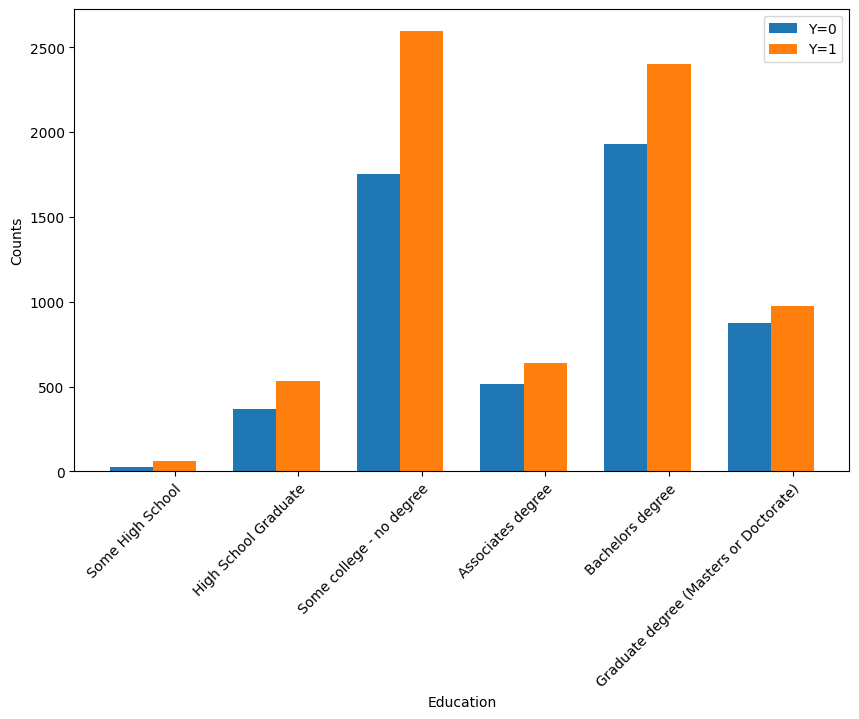

In [183]:
fig_education, axes_education = plt.subplots( figsize=(10, 6) )

bar_width = 0.35
x_ticks = np.arange( len(educationOrder) )

bars_y0_education = axes_education.bar( x_ticks, zero_counts_education.values(), bar_width, label='Y=0' )
bars_y1_education = axes_education.bar( x_ticks + bar_width, one_counts_education.values(), bar_width, label='Y=1' )

axes_education.set_xlabel('Education')
axes_education.set_ylabel('Counts')
axes_education.set_xticks( x_ticks + bar_width)
axes_education.set_xticklabels(educationOrder, rotation=45, ha='right', rotation_mode='anchor')
axes_education.legend()

plt.show()

In [184]:
education_ratios = []
one_counts_educationValues = list(one_counts_education.values())
zero_counts_educationValues = list(zero_counts_education.values())
for i in range(len(one_counts_educationValues)):
    ratio = (one_counts_educationValues[i]) / (one_counts_educationValues[i] + zero_counts_educationValues[i])
    education_ratios.append(ratio)
education_ratios

[0.7159090909090909,
 0.5922651933701657,
 0.5964146173293495,
 0.5533391153512576,
 0.554325259515571,
 0.5264578833693304]

Text(0, 0.5, 'Ratios')

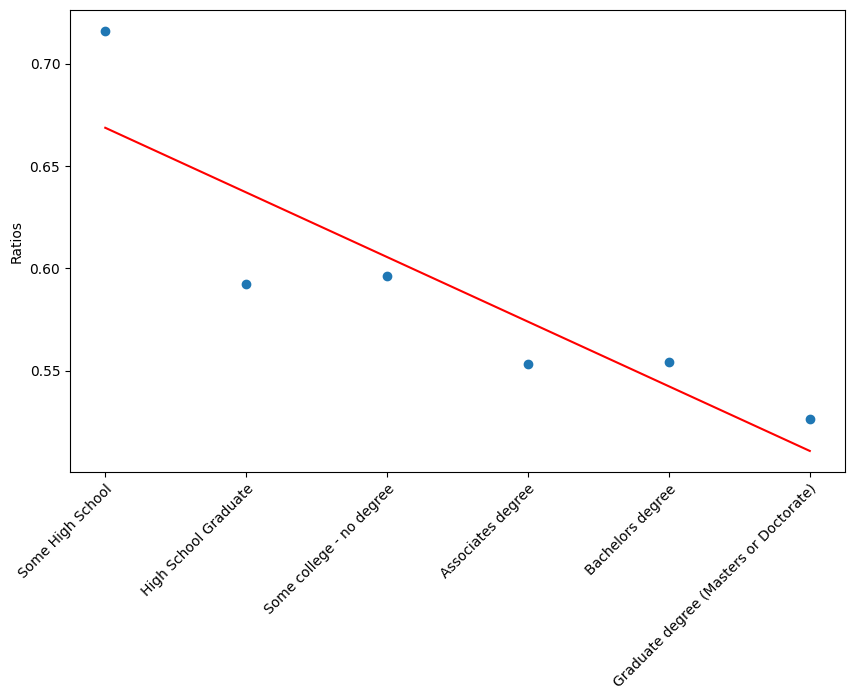

In [185]:
fig_ratios, axes_ratios = plt.subplots( figsize=(10, 6) )
xticks = np.arange(len(educationOrder))
axes_ratios.scatter( xticks, education_ratios )
axes_ratios.plot(xticks, y_pred, color='red')

axes_ratios.set_xticks(xticks)
axes_ratios.set_xticklabels(educationOrder, rotation=45, ha='right', rotation_mode='anchor')
axes_ratios.set_ylabel("Ratios")

In [186]:
model = LinearRegression()
y_data = np.array(education_ratios)
x_data = np.array(xticks).reshape(-1, 1)
model.fit( x_data, y_data )
y_pred = model.predict(x_data)

As we can see with the above scatter, we can infere on our data that as education 'increases' than the ratio of acceptance of the coupon will decrease. So using an Ordinal Encoder can be better than using a One Hot Encoder - It can be tested.

In [187]:
X_final.drop(columns=['education'])
X_final['education'] = X_testEducation
X_final

,has_children,education,occupation,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,...,age_36,age_41,age_46,age_50plus,age_below21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed
0,1,2.0,Unemployed,NaN,never,never,NaN,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,2.0,Unemployed,NaN,never,never,NaN,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,2.0,Unemployed,NaN,never,never,NaN,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,2.0,Unemployed,NaN,never,never,NaN,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,2.0,Unemployed,NaN,never,never,NaN,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,0,4.0,Sales & Related,NaN,never,never,1~3,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12680,0,4.0,Sales & Related,NaN,never,never,1~3,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12681,0,4.0,Sales & Related,NaN,never,never,1~3,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12682,0,4.0,Sales & Related,NaN,never,never,1~3,4~8,1~3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Ocupation
Ocupation has no Ordinal values between them. So we will use a One Hot Encoder

In [188]:
one_hot_encoder_occupation = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
one_hot_encoder_occupationTransform = one_hot_encoder_occupation.fit_transform(X[['occupation']])
X_final = pd.concat( [X_final, one_hot_encoder_occupationTransform], axis=1 ).drop(columns=['occupation'])
X_final

,has_children,education,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,...,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed
0,1,2.0,NaN,never,never,NaN,4~8,1~3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,2.0,NaN,never,never,NaN,4~8,1~3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,2.0,NaN,never,never,NaN,4~8,1~3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,2.0,NaN,never,never,NaN,4~8,1~3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,2.0,NaN,never,never,NaN,4~8,1~3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,0,4.0,NaN,never,never,1~3,4~8,1~3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12680,0,4.0,NaN,never,never,1~3,4~8,1~3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12681,0,4.0,NaN,never,never,1~3,4~8,1~3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12682,0,4.0,NaN,never,never,1~3,4~8,1~3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [189]:
# car attribute is not in the jupyter notebook so i will drop it 
X_final.drop(columns=['car'])

,has_children,education,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,...,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed
0,1,2.0,never,never,NaN,4~8,1~3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,2.0,never,never,NaN,4~8,1~3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,2.0,never,never,NaN,4~8,1~3,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,2.0,never,never,NaN,4~8,1~3,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,2.0,never,never,NaN,4~8,1~3,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,0,4.0,never,never,1~3,4~8,1~3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12680,0,4.0,never,never,1~3,4~8,1~3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12681,0,4.0,never,never,1~3,4~8,1~3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12682,0,4.0,never,never,1~3,4~8,1~3,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## toCoupon_GEQ15min, toCoupon_GEQ25min, direction_same, direction_opp
this are already one hot encoded variables so we will not change them...

## Testing the already done preprocessing

In [193]:
X_testing_preprocessing = X_final.copy()
X_testing_preprocessing

,has_children,education,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,...,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed
0,1,2.0,NaN,never,never,NaN,4~8,1~3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,2.0,NaN,never,never,NaN,4~8,1~3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,2.0,NaN,never,never,NaN,4~8,1~3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,2.0,NaN,never,never,NaN,4~8,1~3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,2.0,NaN,never,never,NaN,4~8,1~3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,0,4.0,NaN,never,never,1~3,4~8,1~3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12680,0,4.0,NaN,never,never,1~3,4~8,1~3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12681,0,4.0,NaN,never,never,1~3,4~8,1~3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12682,0,4.0,NaN,never,never,1~3,4~8,1~3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
